In [1]:
import numpy as np
import pandas as pd
from osgeo import gdal
import matplotlib.pyplot as plt
import math
import os
import time
from osgeo import ogr, osr
import sys
import random

# getFilelist returns a list with all files of a certain type in a path
def getFilelist(originpath, ftyp, deep = False):
    out   = []
    if deep == False:
        files = os.listdir(originpath)
        for i in files:
            if i.split('.')[-1] in ftyp:
                if originpath.endswith('/'):
                    out.append(originpath + i)
                else:
                    out.append(originpath + '/' + i)
            # else:
            #     print("non-matching file - {} - found".format(i.split('.')[-1]))
    else:
        for path, subdirs, files in os.walk(originpath):
            for i in files:
                if i.split('.')[-1] in ftyp:
                    out.append(os.path.join(path, i))
    return out

def plotter(array, row=1, col=1, names=False, title=False):

    # Plot the slices
    fig, axes = plt.subplots(row, col, figsize=(col*5, row*5), constrained_layout=False)  # 4 slices
    # Create a colormap
    cmap = plt.cm.viridis
    
    if col != 1:
        slice_indices = np.linspace(0, (row * col) -1, col * row, dtype=int)
        #print(slice_indices)
        for ax, idx in zip(axes.ravel(), slice_indices):
            im = ax.imshow(array[:, :, idx], cmap=cmap)
            if names == False:
                ax.set_title(f"Slice {idx}")
            else:
                ax.set_title(names[idx], fontsize=10)     
            # ax.set_xticks([0, 32, 64, 96, 127])
            # ax.set_yticks([0, 32, 64, 96, 127])
            # ax.set_xticklabels(['X0', 'X32', 'X64', 'X96', 'X127'])
            # ax.set_yticklabels(['Y0', 'Y32', 'Y64', 'Y96', 'Y127'])

            cbar_ax = ax.inset_axes([0.1, -0.2, 0.8, 0.05])  # [x, y, width, height]
            cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
            cbar.set_label('Value Scale')
    else:
            im = axes.imshow(array[:, :], cmap=cmap)
            #ax.set_xticks([0, 32, 64, 96, 127])
            #ax.set_yticks([0, 32, 64, 96, 127])
            #ax.set_xticklabels(['X0', 'X32', 'X64', 'X96', 'X127'])
            #ax.set_yticklabels(['Y0', 'Y32', 'Y64', 'Y96', 'Y127'])

            cbar_ax = axes.inset_axes([0.1, -0.2, 0.8, 0.05])  # [x, y, width, height]
            cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
            cbar.set_label('Value Scale')
 
    fig.subplots_adjust(hspace=0.2, wspace=0.2)
    if title != False:
        fig.suptitle(f'Date is {title[0]} at canals {title[1]}', fontsize=12)
    plt.tight_layout()
    plt.show()

def getNestedListMinLengthIndex(nestedList):
    res = [index for index, band in enumerate(nestedList) if len(band) == min([len(i) for i in nestedList])]
    return res[0]

def getBandNames(rasterstack):
    bands = []
    ds = gdal.Open(rasterstack)
    numberBands = ds.RasterCount
    for i in range(numberBands):
        bands.append(ds.GetRasterBand(i+1).GetDescription())
    return bands

def makeZeroNAN(arr):
    arr[arr == 0] = np.nan
    return arr

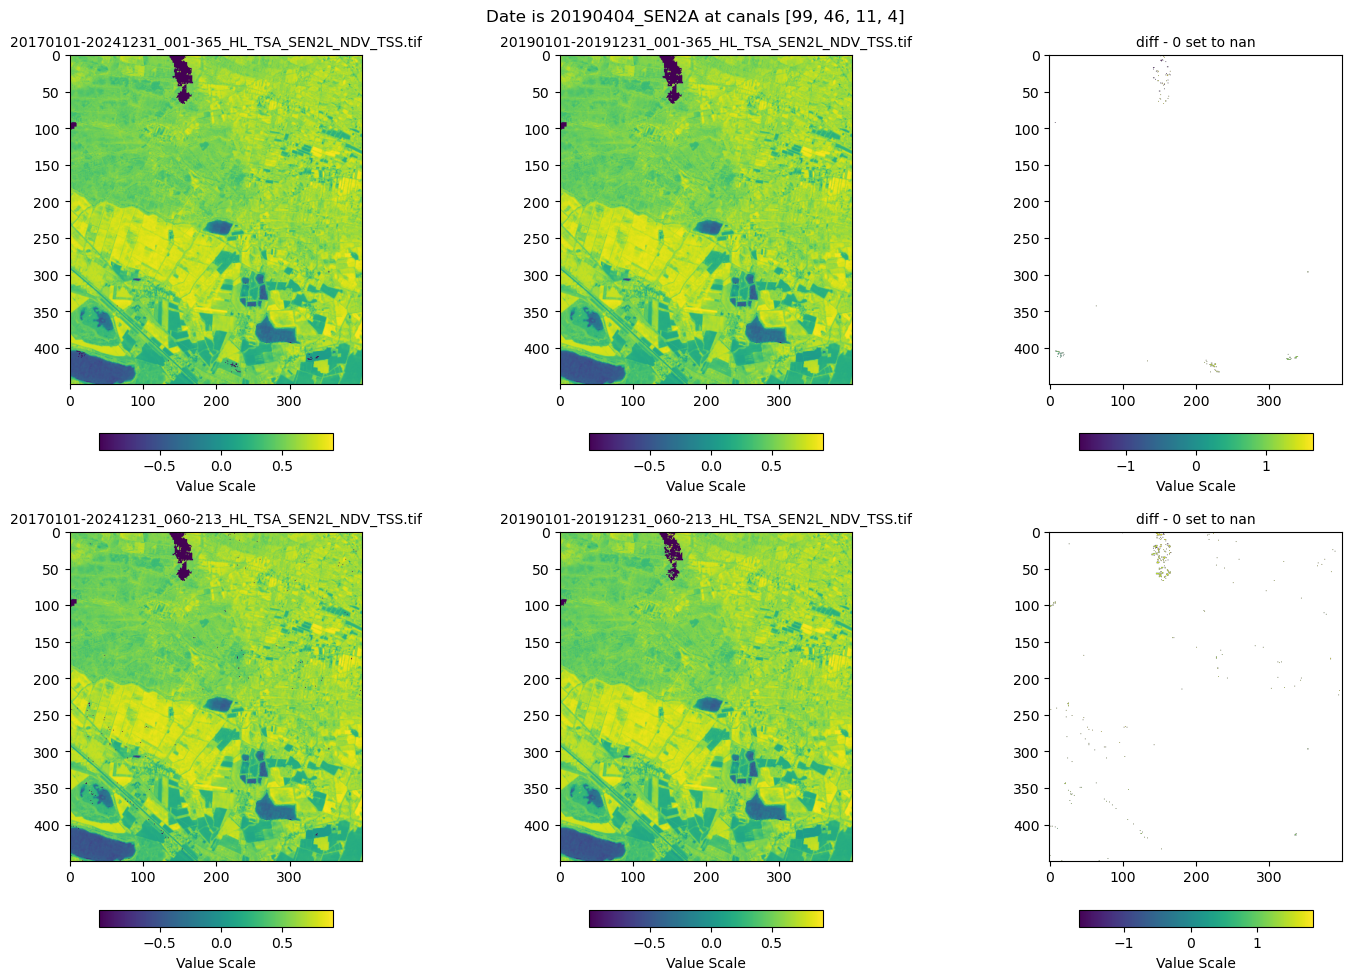

In [4]:
path = '/data/Aldhani/eoagritwin/force/output/X0071_Y0045/'
files = getFilelist(path, '.tif', deep=True)
TSS = sorted([file for file in files if 'TSS' in file])
TSI = sorted([file for file in files if 'TSI' in file])
FBM = sorted([file for file in files if 'FBM' in file])
STM = sorted([file for file in files if 'STM' in file])

block = 'TSS'
if block == 'TSI':
    dat = eval(block)[:2]
else:
    dat = eval(block)
#random.seed(0)
bandL = []
for i in range(len(dat)):
    bandL.append(getBandNames(dat[i]))

samp = random.choice(bandL[getNestedListMinLengthIndex(bandL)])
#get Bands across datasets for sample
ind = [i for band in bandL for i, b in enumerate(band) if b == samp]
# load the bands with the same timestamp in a stack
arr = []
for i in range(len(dat)):
    ds = gdal.Open(dat[i])
    # print(ds.GetRasterBand(ind[i]+1).GetDescription())
    arr.append(ds.GetRasterBand(ind[i]+1).ReadAsArray())
arr = np.dstack(arr)
arr = arr / 10000
#arr[arr == -0.9999] = np.nan

start1 = 1050
start2 = 550
end1 = 1550
end2 = 950

if block in ['TSS', 'FBM', 'STM']:
    image_order = [0,2,1,3]#[0,2,1,3]
    namL = []
    extractor = 0
    for i in range(len(image_order) + int(len(image_order)/2)):
        if i in [2,5]:
            namL.append('diff - 0 set to nan') 
        else:
            namL.append(dat[image_order[extractor]].split('/')[-1])
            extractor += 1
    

    inputList = [arr[start1:end1, start2:end2, image_order[0]], 
                arr[start1:end1, start2:end2,image_order[1]],
                makeZeroNAN(np.diff(arr[start1:end1, start2:end2,[0,2]], axis=2)), 
                arr[start1:end1, start2:end2, image_order[2]], 
                arr[start1:end1, start2:end2, image_order[3]],
                makeZeroNAN(np.diff(arr[start1:end1, start2:end2,[1,3]], axis=2))]
    rows = 2

    plotter(np.dstack((inputList)), rows, int(len(inputList)/rows), names=namL, title=[samp, str([indi+1 for indi in ind])])

elif block == 'TSI':
    image_order = [0,1]#[2,3]
    namL = []
    extractor = 0
    for i in range(len(image_order) + int(len(image_order)/2)):
        if i in [2,5]:
            namL.append('diff - 0 set to nan') 
        else:
            namL.append(dat[image_order[extractor]].split('/')[-1])
            extractor += 1
    inputList = [arr[start1:end1, start2:end2, 0], 
                arr[start1:end1, start2:end2,1],
                makeZeroNAN(np.diff(arr[start1:end1, start2:end2,[0,1]], axis=2))]
    rows = 1

    plotter(np.dstack((inputList)), rows, int(len(inputList)/rows), names=namL, title=[samp, str([indi+1 for indi in ind])])

In [ ]:
# let's look into difference of TSI, FBM, STM
path = '/data/Aldhani/eoagritwin/force/output/monthly/X0071_Y0045/'
files = getFilelist(path, '.tif', deep=True)
TSS = sorted([file for file in files if 'TSS' in file])
TSI = sorted([file for file in files if 'TSI' in file])
FBM = sorted([file for file in files if 'FBM' in file])
STM = sorted([file for file in files if 'STM' in file])


In [76]:
block = 'FBM'
dat = eval(block)
#random.seed(0)
bandL = []
for i in range(len(dat)):
    bandL.append(getBandNames(dat[i]))

samp = random.choice(bandL[getNestedListMinLengthIndex(bandL)])
#get Bands across datasets for sample
ind = [i for band in bandL for i, b in enumerate(band) if b == samp]
# load the bands with the same timestamp in a stack
arr = []
for i in range(len(dat)):
    ds = gdal.Open(dat[i])
    # print(ds.GetRasterBand(ind[i]+1).GetDescription())
    arr.append(ds.GetRasterBand(ind[i]+1).ReadAsArray())
arr = np.dstack(arr)
arr = arr / 10000
#arr[arr == -0.9999] = np.nan

start1 = 1050
start2 = 550
end1 = 1550
end2 = 950

if block in ['TSS', 'FBM', 'STM']:
    image_order = [0,1,2,3,4,5]#[0,2,1,3]
    namL = []
    extractor = 0
    for i in range(len(image_order)):# + int(len(image_order)/2)):
        # if i in [2,5]:
        #     namL.append('diff - 0 set to nan') 
        # else:
        namL.append(dat[image_order[extractor]].split('/')[-1])
        extractor += 1
    

    inputList = [arr[start1:end1, start2:end2, image_order[0]], 
                arr[start1:end1, start2:end2,image_order[1]],
                arr[start1:end1, start2:end2,image_order[2]],
                arr[start1:end1, start2:end2,image_order[3]],
                #makeZeroNAN(np.diff(arr[start1:end1, start2:end2,[0,2]], axis=2)), 
                arr[start1:end1, start2:end2, image_order[4]], 
                arr[start1:end1, start2:end2, image_order[5]]]
                #makeZeroNAN(np.diff(arr[start1:end1, start2:end2,[1,3]], axis=2))]
    rows = 2

    plotter(np.dstack((inputList)), rows, int(len(inputList)/rows), names=namL, title=[samp, str([indi+1 for indi in ind])])

elif block == 'TSI':
    image_order = [0,1,2,3,4,5,6]
    namL = []
    extractor = 0
    for i in range(len(image_order)):# + int(len(image_order)/2)):
        # if i in [2,5]:
        #     namL.append('diff - 0 set to nan') 
        # else:
        namL.append(dat[image_order[extractor]].split('/')[-1])
        extractor += 1
    inputList = [arr[start1:end1, start2:end2, 0], 
                arr[start1:end1, start2:end2, 1],
                arr[start1:end1, start2:end2, 2],
                arr[start1:end1, start2:end2, 3],
                arr[start1:end1, start2:end2, 4],
                arr[start1:end1, start2:end2, 5]]#,
                #makeZeroNAN(np.diff(arr[start1:end1, start2:end2,[0,1]], axis=2))]
    rows = 1

    plotter(np.dstack((inputList)), rows, int(len(inputList)/rows), names=namL, title=[samp, str([indi+1 for indi in ind])])

IndexError: list index out of range

In [59]:
bandL[getNestedListMinLengthIndex(bandL)]

['20190101',
 '20190106',
 '20190111',
 '20190116',
 '20190121',
 '20190126',
 '20190131',
 '20190205',
 '20190210',
 '20190215',
 '20190220',
 '20190225',
 '20190302',
 '20190307',
 '20190312',
 '20190317',
 '20190322',
 '20190327',
 '20190401',
 '20190406',
 '20190411',
 '20190416',
 '20190421',
 '20190426',
 '20190501',
 '20190506',
 '20190511',
 '20190516',
 '20190521',
 '20190526',
 '20190531',
 '20190605',
 '20190610',
 '20190615',
 '20190620',
 '20190625',
 '20190630',
 '20190705',
 '20190710',
 '20190715',
 '20190720',
 '20190725',
 '20190730',
 '20190804',
 '20190809',
 '20190814',
 '20190819',
 '20190824',
 '20190829',
 '20190903',
 '20190908',
 '20190913',
 '20190918',
 '20190923',
 '20190928',
 '20191003',
 '20191008',
 '20191013',
 '20191018',
 '20191023',
 '20191028',
 '20191102',
 '20191107',
 '20191112',
 '20191117',
 '20191122',
 '20191127',
 '20191202',
 '20191207',
 '20191212',
 '20191217',
 '20191222',
 '20191227']